In [1]:
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import math
import time
import multiprocessing
from multiprocessing import Pool
import matplotlib.pyplot as plt

In [2]:
# cpu_count=multiprocessing.cpu_count()
cpu_count = 1

In [3]:
def stround(x):
    c = np.floor(x)
    return c + ((x - c) > np.random.rand())

def activate(x):
    sigma = 1/ (1 + np.exp(-x))
    return sigma

def energy(a, b, W, visible_vector):
    '''
    Enerexponentf Restricted Bolztmann machine for given parameters.
    CAUTION: a, b must be column vector. 
    '''
    #W.shape = (n_hid, 784)
    l = len(b) #n_hid
    v = visible_vector.reshape(784,1) #v.shape = (784,1)
    a, b = a.reshape(784,1), b.reshape(l,1) #both are column vector
    h = stround(activate(np.matmul(v.T,W.T).T + b)) #column vector
    e = -np.dot(a.T,v) - np.dot(b.T,h) - np.matmul(np.matmul(v.T, W.T), h) #a scalar
    
    return e

def initial(lattice_size):
    '''
    Making random configuration which consists of 0/1.
    '''
    config = np.random.randint(2, size = (lattice_size, lattice_size))
    return config

def function1(index_E1):
    global e
    global ini_index
#     ini_index=0
    for k in range(len(index_E1)-1):
        c_1, c_2 = index_E1[k][1], index_E1[k+1][1]
        if e >= c_1 and e <= (c_1 + c_2)/2:
            ini_index = index_E1[k][0]
            break
        elif e >= (c_1 + c_2)/2 and e <= c_2: 
            ini_index = index_E1[k+1][0]
            break
    return ini_index

def function2(index_E2):
    global ee
    global cha_index
#     cha_index=0
    for k in range(len(index_E2)-1):
        c_1, c_2 = index_E2[k][1], index_E2[k+1][1]
        if ee >= c_1 and ee <= (c_1 + c_2)/2:
            cha_index = index_E2[k][0]
            break
        elif ee >= (c_1 + c_2)/2 and ee <= c_2: 
            cha_index = index_E2[k+1][0]
            break
    return cha_index

def multi_processing(index_E, function0):
#     global e
#     global ee
#     chunks = [index_E[i::cpu_count] for i in range(cpu_count)]
#     chunks = [index_E[:int(len(index_E)/2)], index_E[int(len(index_E)/2):]]
#     chunks = [index_E[i:i+n] for i in range(0, len(index_E), cpu_count)]
    chunks = [index_E[i:i+int(len(index_E)/cpu_count)] for i in range(0, len(index_E), int(len(index_E)/cpu_count))]
    pool = Pool(processes=cpu_count)
    result = pool.map_async(function0, chunks)
    pool.close() # shut down the pool
#     print(result.get())
    return max(result.get())

In [4]:
e=0; ee=0
ini_index=0
cha_index=0

def wang_landau(a,b,W,config_E): #lattice_size = 28 for MNIST RBM
    '''
    Trained model의 parameters를 넣고, sample_size만큼의 spin flip을 "시도"합니다.
    Energy space를 1간격으로 uniform하게 나눕니다.
    '''
    global e
    global ee
    global ini_index
    global cha_index
#     config = initial(28) #초기 이미지 만들기
    config=config_E.keys()[0]
    ######## 이 부분은 경험적으로 얻은 값을 대입하시면 됩니다.####################
    E_min= min(config_E.keys()*1.1)
    E_max= max(config_E.keys()*1.1)
    E = np.linspace(E_min+1, E_max, 10)
    ##############################################################################

    e = energy(a, b, W, config) #initial configuration의 energy입니다.
    ln_gE = np.zeros(len(E))
    Histogram = np.zeros(len(E))
    log_modi_factor = 1
    
    index_E1, index_E2 = [], []
    ini_index, cha_index = 0, 0
    
    count_flat, count_sweep = 0, 0

    for i in enumerate(E): 
        index_E1.append(i)
    for j in enumerate(E): 
        index_E2.append(j)
    
    while count_flat <= 27:
        count_sweep += 1
        for i in range(28):
            for j in range(28):
                s = config[i,j]

                #spin flip
                #count_flip += 1
                if s == 0:
                    s = 1
                else:
                    s = 0
                config[i,j] = s
                ee = energy(a, b, W, config) #spin을 하나 flip한 사진의 에너지를 구합니다.
                # \beta : 여기에서 에너지 조건을 준다음, 바뀐 에너지가 1500보다 크면 loop을 끝내는 식으로 가야할 것 같습니다. 
                if ee < E_max:
                    for k in range(len(index_E1)-1):
                        c_1, c_2 = index_E1[k][1], index_E1[k+1][1]
                        if e >= c_1 and e <= (c_1 + c_2)/2:
                            ini_index = index_E1[k][0]
                            break
                        elif e >= (c_1 + c_2)/2 and e <= c_2: 
                            ini_index = index_E1[k+1][0]
                            break

                    for k in range(len(index_E2)-1):
                        c_1, c_2 = index_E2[k][1], index_E2[k+1][1]
                        if ee >= c_1 and ee <= (c_1 + c_2)/2:
                            cha_index = index_E2[k][0]
                            break
                        elif ee >= (c_1 + c_2)/2 and ee <= c_2: 
                            cha_index = index_E2[k+1][0]
                            break
#                     ini_index=multi_processing(index_E1, function1)
#                     cha_index=multi_processing(index_E2, function2)
                    p = np.exp(ln_gE[ini_index] - ln_gE[cha_index])
#                     print(ini_index,cha_index)
                    if p > np.random.rand():
                        s = s #keeps flipped value
                        Histogram[cha_index] += 1
                        ln_gE[cha_index] += log_modi_factor
                        e = ee
                    else:
                        if s == 0:
                            s = 1
                        else:
                            s = 0 
                        config[i,j] = s #spin flip is rejected
                        Histogram[ini_index] += 1
                        ln_gE[ini_index] += log_modi_factor
                        e = e
                else: #다시 원상태로 복귀하고 loop를 탈출
                    d = config[i,j]
                    if d == 0:
                        d = 1
                    elif d == 1:
                        d = 0
                    config[i,j] = d
                print(e, ee)    
        #Is the Histogram flat?
        print(count_sweep)
        if count_sweep % 10 == 0:
            Havg = np.mean(Histogram)
            Hmin = min(Histogram)
            print(list(Histogram.astype(int)))
            if Havg*0.80 <= Hmin:
                Histogram = np.zeros_like(E)
                log_modi_factor *= 0.5
                count_flat += 1
                print('==================================================================')
                print(f"{count_flat}")
    return ln_gE

In [5]:
a = pd.read_pickle('parameters/n_hid=4_vol_12000_bias_v.pkl')
b = pd.read_pickle('parameters/n_hid=4_vol_12000_bias_h.pkl')
W = pd.read_pickle('parameters/n_hid=4_vol_12000_weight.pkl')

config_E=pd.read_pickle('combined_config_E.pkl')

In [6]:
start = time.time()
lngE = wang_landau(b,,bW,config_EW)
end = time.time() - start
print(f"Takes {end/60} min")

NameError: name 'ab' is not defined

In [ ]:
E = []
config = initial(28)
#for i in tqdm(range(1000), desc = 'check'):
for j in range(28):
    for k in range(28):
        s = config[j,k]
        #spin flip
        #count_flip += 1
        if s == 0:
            s = 1
        else:
            s = 0
        config[j,k] = s
        ee = energy(a, b, W, config) #spin을 하나 flip한 사진의 에너지를 구합니다.
        s = config[j,k]
        if s == 0:
            s = 1
        else:
            s = 0
        config[j,k] = s

        E.append(ee)

In [35]:
np.mean(E - min(E))

13.090042949888923

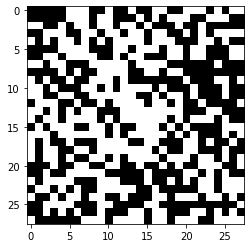

In [44]:
plt.imshow(initial(28), cmap = 'gray')

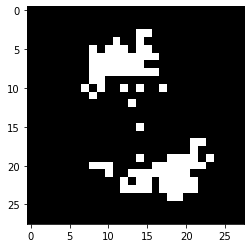

In [43]:
plt.imshow(config2, cmap = 'gray')

In [15]:
E1 = []
config = np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]).reshape(28,28)
E1.append(energy(a,b,W,config))

#for i in tqdm(range(1000), desc = 'check'):
for j in range(28):
    for k in range(28):
        s = config[j,k]
        #spin flip
        #count_flip += 1
        if s == 0:
            s = 1
        else:
            s = 0
        config[j,k] = s
        ee = energy(a, b, W, config) #spin을 하나 flip한 사진의 에너지를 구합니다.
        s = config[j,k]
        if s == 0:
            s = 1
        else:
            s = 0
        config[j,k] = s

        E1.append(ee)


In [16]:
E1

[array([[-79.13021155]]),
 array([[-63.79843127]]),
 array([[-63.79018857]]),
 array([[-64.72783389]]),
 array([[-64.15617093]]),
 array([[-64.78548072]]),
 array([[-63.05815085]]),
 array([[-63.7744449]]),
 array([[-62.77202448]]),
 array([[-64.52400722]]),
 array([[-63.97332682]]),
 array([[-63.2936395]]),
 array([[-63.36322518]]),
 array([[-64.47746768]]),
 array([[-64.16437014]]),
 array([[-64.09106945]]),
 array([[-64.48988857]]),
 array([[-63.45560165]]),
 array([[-64.35484096]]),
 array([[-63.94130977]]),
 array([[-64.50656082]]),
 array([[-64.12380316]]),
 array([[-63.22370746]]),
 array([[-64.36517718]]),
 array([[-64.18826487]]),
 array([[-64.32127251]]),
 array([[-64.54728838]]),
 array([[-64.49374374]]),
 array([[-64.227721]]),
 array([[-63.92800751]]),
 array([[-64.19227418]]),
 array([[-64.58116677]]),
 array([[-63.94103893]]),
 array([[-62.98865684]]),
 array([[-63.72736701]]),
 array([[-63.56618657]]),
 array([[-63.6544902]]),
 array([[-64.13772949]]),
 array([[-64.3704

In [46]:
min(E1)

array([[72.35548372]])

"학습된 애들"만 이용해서 free energy..<br>
바운더리를 주자

In [11]:
Z = np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]).reshape(28,28)

In [12]:
energy(a,b,W,Z)

array([[-79.13021155]])